# Benchmarking

In [1]:
import sys
import time
import os
import pandas as pd
import numpy as np
from functools import partial
# sys.path.append('/Users/calum/Developer/pyzx-heuristics-master')
# import pyzx as zx_heuristics
sys.path.append('..')
import pyzx as zx
from benchmarking import benchmark

In [2]:
b = benchmark(dirpath='benchmark')
# b = benchmark()
# b.load_circuits(os.path.join('..', 'circuits', 'benchmarking', 'Fast', 'before'), group_name='fast')
# b.load_circuits('generated_circuits', group_name='generated')
# b.load_circuits(os.path.join('..', 'circuits', 'benchmarking', 'Fast', 'nrscm'), group_name='fast', simp_strategy='NRSCM')
b.show_attributes()

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_simp', 't_opt']
Loaded functions:  ['Basic', 'cFlow', 'gFlow', 'Heur', 'Int_Clifford', 'Full_Reduce', 'cFlow_1']
Loaded routines:  ['NRSCM']
Loaded circuit groups:  ['fast', 'generated']


,Original,Basic,Full_Reduce,Heur,Int_Clifford,NRSCM,cFlow,cFlow_1,gFlow
fast,Y,Y,Y,Y,Y,Y,Y,Y,Y
generated,Y,Y,Y,Y,Y,-,Y,Y,Y


In [3]:
def cFlow_reduce(c, params):
    t0 = time.time()
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce(g,x=params, quiet=True)
    t1 = time.time()
    c2 = zx.extract.extract_simple(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    t2 = time.time()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4, t1-t0, t2-t0
    return c3, t1-t0, t2-t0

def gFlow_reduce(c, params):
    t0 = time.time()
    g = c.to_graph()
    zx.simplify.to_gh(g)
    g2 = zx.simplify.flow_reduce(g,x=params, flow = 'g', quiet=True)
    t1 = time.time()
    c2 = zx.extract.extract_circuit(g2, up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    t2 = time.time()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4, t1-t0, t2-t0
    return c3, t1-t0, t2-t0

def zx_heur(c):
    t0 = time.time()
    g = c.to_graph()
    g = zx_heuristics.simplify.teleport_reduce(g)
    g.track_phases = False
    zx_heuristics.simplify.greedy_simp_neighbors(g)
    t1 = time.time()
    c2 = zx_heuristics.extract_circuit(g, up_to_perm=True).to_basic_gates()
    c3 = zx_heuristics.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx_heuristics.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    t2 = time.time()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4, t1-t0, t2-t0
    return c3, t1-t0, t2-t0

def basic(c):
    c1 = zx.optimize.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.optimize.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2
    return c1

def int_cliff(c):
    g = c.to_graph()
    zx.simplify.interior_clifford_simp(g,quiet=True)
    c2 = zx.extract_circuit(g,up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

def full_reduce(c):
    g = c.to_graph()
    zx.simplify.full_reduce(g,quiet=True)
    c2 = zx.extract_circuit(g,up_to_perm=True).to_basic_gates()
    c3 = zx.optimize.basic_optimization(c2.copy(), do_swaps=False).to_basic_gates()
    c4 = zx.optimize.basic_optimization(c2.copy(), do_swaps=True).to_basic_gates()
    if c4.twoqubitcount() < c3.twoqubitcount(): return c4
    return c3

In [10]:
base_params = [1,1,1,0,0,0,0,0,0]
opt_params = [[0.30, 0.39, 0.31, -1.81, 2.47, 0.35, 1.08, -1.15, 1.11], #1
        [0.34, 0.37, 0.29, 22.32, 2.33, -18.51, 1.92, -26.60, -9.51], #2
        [0.50, 0.06, 0.44, -3.99, 1.94, -16.24, -14.81, -11.30, -11.49], #3
        [0.51, 0.04, 0.45, -13.43, -7.01, -14.67, -2.37, -5.75, -2.45], #4
        [0.50, 0.06, 0.44, 0.68, 14.78, -14.58, 8.62, -1.26, -10.86], #5
        [0.51, 0.04, 0.45, -7.08, 10.69, -8.13, 3.25, 0.71, -16.19], #6
        [0.29, 0.21, 0.50, 1.42, -11.92, -8.86, -10.04, -16.48, 2.84], #7
        [0.08, 0.70, 0.22, -11.13, 3.59, -5.92, 10.02, -6.71, -5.46], #8
        [0.50, 0.06, 0.44, 5.83, 10.42, 2.09, 3.23, -2.41, -5.48], #9
        [0.34, 0.37, 0.29, 12.76, 16.65, -5.62, -8.72, -21.95, 6.17], #10
        [0.3, 0.5, 0.2, -1.81, 2.47, 0.35, 1.08, -1.15, 1.11], #11
        [0.45, 0.55, 0.0, -1.81, 2.47, 0.35, 1.08, -1.15, 1.11]] #12

# b.add_simplification_func(zx_heur, 'Heur', groups_to_run=['generated'],verify=False)
# b.add_simplification_func(basic, 'Basic', groups_to_run=['generated'],verify=False)
# b.add_simplification_func(int_cliff, 'Int_Clifford', groups_to_run='all',verify=False)
# b.add_simplification_func(full_reduce, 'Full_Reduce', groups_to_run='all',verify=False)
# b.add_simplification_func(partial(cFlow_reduce, params=base_params), 'cFlow', groups_to_run=['generated'],verify=False)
# b.add_simplification_func(partial(gFlow_reduce, params=base_params), 'gFlow', groups_to_run=['generated'],verify=False)
for i, params in enumerate(opt_params):
        # b.add_simplification_func(partial(cFlow_reduce, params=params), f'cFlow_{i+1}', groups_to_run='all',verify=False)
        b.add_simplification_func(partial(gFlow_reduce, params=params), f'gFlow_{i+1}', groups_to_run='all',verify=False)

Processing gFlow_1 on csum_mux_9_corrected                            :   4%|▍         | 2/52 [58:16<24:16:52, 1748.26s/it]


KeyboardInterrupt: 

In [9]:
b.show_attributes()

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_simp', 't_opt']
Loaded functions:  ['Basic', 'cFlow', 'gFlow', 'Heur', 'Int_Clifford', 'Full_Reduce', 'cFlow_1', 'cFlow_2', 'cFlow_3', 'cFlow_4', 'cFlow_5', 'cFlow_6', 'cFlow_7', 'cFlow_8', 'cFlow_9', 'cFlow_10', 'cFlow_11', 'cFlow_12', 'gFlow_1']
Loaded routines:  ['NRSCM']
Loaded circuit groups:  ['fast', 'generated']


,Original,Basic,Full_Reduce,Heur,Int_Clifford,NRSCM,cFlow,cFlow_1,cFlow_10,cFlow_11,cFlow_12,cFlow_2,cFlow_3,cFlow_4,cFlow_5,cFlow_6,cFlow_7,cFlow_8,cFlow_9,gFlow,gFlow_1
fast,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
generated,Y,Y,Y,Y,Y,-,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,-


In [8]:
df = b.df(groups=['fast'],
     routines='all',
     funcs='all',
     atts=['Qubits', '2Q Count'])

  0%|          | 0/11 [00:00<?, ?it/s]

Processing Full_Reduce on P_t = 0.15              : 100%|██████████| 11/11 [04:15<00:00, 23.20s/it]


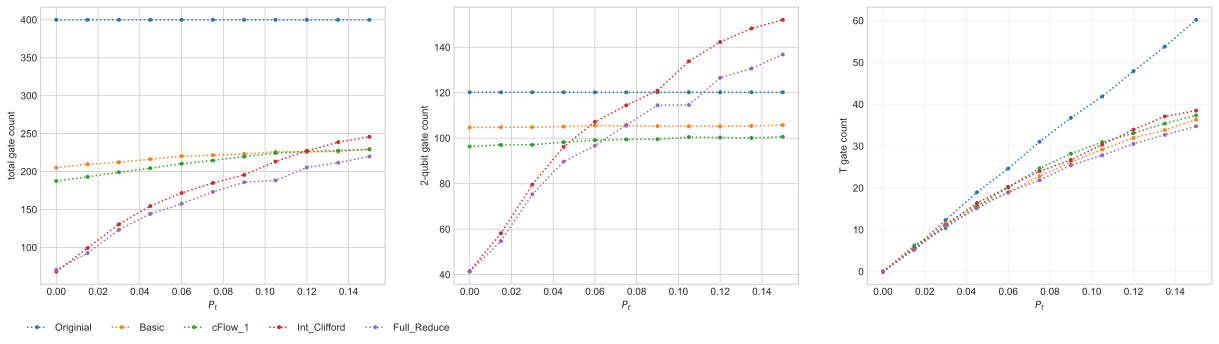

In [13]:
funcs = ['Basic', 'cFlow_1', 'Int_Clifford', 'Full_Reduce']
t_probs = [0.015*i for i in range(11)]
fig = b.Pt_graphs(funcs=funcs, qubits=8, depth=400, cnot_prob=0.3, t_probs=t_probs, ys=['Gates','2Q Count','T Count'], reps=20, overwrite=False, random_seed=42)

In [17]:
b.save(dirpath='benchmark')